In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact_manual
import ipywidgets as wd

from os import system

''' GLOBAL CONSTANTS '''
PI = 3.141592
BOLTZMANN = 1.380649E-23 #N·m/K
AVOGADROS = 6.02214076E+23 #mol⁻¹
TEMP = 25 + 273.15 #K
g = 9.81 #m/s²

DIELECTRIC_WATER = 80
PERMITIVITY_FREE_SPACE = 8.854E-12 #C/m·J
ELEMENTARY_CHARGE = 1.60219E-19 #C

# DLVO profiles

\begin{equation}
    \Phi_T(x) = \Phi_{\rm dl}(x) + \Phi_{\rm vdW}(x) + \Phi_{\rm Born}(x)
\end{equation}

- $\Phi_T(x)$ : total potential [J]
- $\Phi_{\rm dl}$ : double layer interaction potential [J]
- $\Phi_{\rm vdW}$ : van der Waals interaction [J]
- $\Phi_{\rm Born}$ : Born interaction [J]

In [2]:
def DLVO_T(Phi_dl,Phi_vdw,Phi_born):
    return Phi_dl + Phi_vdw + Phi_born

## Double layer interaction $\Phi_{\rm dl}$

\begin{equation}
    \Phi_{\rm dl}(x) = 
        \pi 
        \epsilon 
        \epsilon_0 
        r_p
        \left[
            2 
            \psi_p 
            \psi_c 
            \ln{\left(
                \dfrac{1+ \exp{\left(-\kappa x\right)}}
                    {1 - \exp{\left(-\kappa x\right)}}
                \right)
                }
            + 
            \left( \psi_p^2 + \psi_c^2 \right) 
            \ln{\left(1 - \exp{\left(-2 \kappa x\right)}\right)} 
        \right]
\end{equation}

- $\epsilon$ : dielectric constant of water [-]
- $\epsilon_0$ : permitivity of free space [C/m·J]
- $r_p$ : radius of the colloid particle [m]
- $\psi_p$, $\psi_c$ : surface potential of the particle and the collector [V]
- $\kappa$ : inverse Debye-Huckel distance [m⁻¹]

In [3]:
def DLVO_dl(rp,psip,psic,kappa,x):
    C1 = PI * DIELECTRIC_WATER * PERMITIVITY_FREE_SPACE * rp
    C20 = 2 * psip * psic 
    C210= 1 + np.exp(-kappa*x)
    C211= 1 - np.exp(-kappa*x)
    C21 = np.log(C210/C211)
    C30 = psip**2 + psic**2
    C31 = np.log(1-np.exp(-2*kappa*x))
    return C1 *((C20*C21) + (C30*C31))

### Debye-Huckel lenght $1/\kappa$

\begin{equation}
    \kappa = 
    \left(
    \dfrac{2000 I N_A e^2}
        {\epsilon \epsilon_0 K_B T}
    \right)^{1/2}
\end{equation}

- $N_A$ : Avogadro's number [mol⁻¹]
- $e$ : elementary (electron) charge [V]
- $I$ : ionic strenght [mol/L]
- $K_B$ : Boltzmann constant [N·m/K]
- $T$ : absolute temperature [K]

In [4]:
def DebbyHuckel(I):
    return np.power(2000*I*AVOGADROS*ELEMENTARY_CHARGE**2/(DIELECTRIC_WATER*PERMITIVITY_FREE_SPACE*BOLTZMANN*TEMP),0.5)

### Ionic Strenght I

\begin{equation}
    I = \dfrac{1}{2}\sum_{i}{c_iz_i^2}
\end{equation}

- $c_i$ concentration of the ion $i$ in the solution [mol/L]
- $z_i$ is the valence of the ion $i$ [-]

In [5]:
def IonicStrenght(c,z):
    return 0.5 * np.sum(np.multiply(c,np.power(z,2.0)))

## van der Waals interaction $\Phi_{\rm vdW}$

\begin{equation}
    \Phi_{\rm vdW}(x) = -\dfrac{Ar_p}{6x}\left[1 + \dfrac{14x}{\lambda}\right]^{-1}
\end{equation}

- $A$ : Hamaker constant \[J\]
- $\lambda$ : *characteristic* wavelenght = $10^{-7}$m

In [6]:
CHARACTERISTIC_WAVELENGHT = 1.0E-7 #m

In [7]:
def DLVO_vdW(A,rp,x):
    return -A*rp/(6*x)/(1+(14*x/CHARACTERISTIC_WAVELENGHT))

## Born interaction $\Phi_{\rm Born}$

\begin{equation}
    \Phi_{\rm Born}(x) = \dfrac{A\sigma^6}{7560}\left[
        \dfrac{8r_p + x}{\left(2r_p + x\right)^7} + 
        \dfrac{6r_p - x}{x^7}
    \right]
\end{equation}

- $\sigma$ : Born collision parameter = 5Å [m]

In [8]:
BORN_COLLISION_PARAM = 5E-10 #m

In [9]:
def DLVO_Born(A,rp,x):
    return A*(BORN_COLLISION_PARAM**6)/7560 * (((8*rp + x)/(2*rp + x)**7)+((6*rp - x)/(x**7)))

## Calculate a potential profile

This is, the evolution of the potential between the particle and the collector. 

In [10]:
'''CASE CONSTANTS'''

# Collector-particle sizes [m]
dc,dp = 2.0E-3,100.0E-9  
rc,rp = dc/2,dp/2

# Surface charges [V]
psip,psic = -25.0E-3,-25.0E-3

# Hamaker constant
#A = 5.0E-21 # J = N·m
A = 1.0E-20 # J = N·m

# Water chemistry 
concentrations, valences = [0.1,0.1],[1,-1] 
ionicStrenght = IonicStrenght(concentrations,valences)

# Debye Huckel inverse distance
kappa = DebbyHuckel(ionicStrenght)

In [11]:
# Parameters summary
paramSummary = "\
    $d_p$ = {:.1E} m \n\
    $d_c$ = {:.1E} m \n\
    $A$ = {:.1E} J \n\
    $\psi_p$ = {:.1E} V \n\
    $\psi_c$ = {:.1E} V \n\
    $I$ = {} mol/L".format(dp,dc,A,psip,psic,ionicStrenght)

In [12]:
x = np.power(10.,np.linspace(-10,-7,100))

In [13]:
Phi_DoubleLayer = DLVO_dl(rp,psip,psic,kappa,x)
Phi_vanderWaals = DLVO_vdW(A,rp,x)
Phi_BornInterac = DLVO_Born(A,rp,x)
Phi_TotalIntera = DLVO_T(Phi_DoubleLayer,Phi_vanderWaals,Phi_BornInterac)

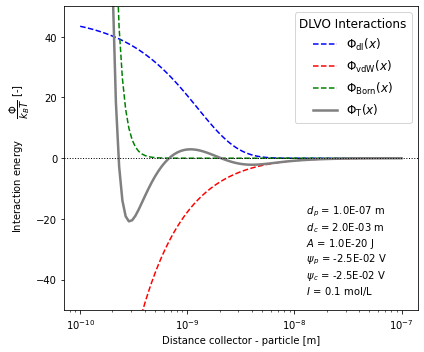

In [14]:
plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

ax1.plot(x,Phi_DoubleLayer/(BOLTZMANN*TEMP),\
         lw=1.5,c="blue",ls="dashed",\
         label="$\Phi_{\\rm dl}(x)$")

ax1.plot(x,Phi_vanderWaals/(BOLTZMANN*TEMP),\
         lw=1.5,c="red",ls="dashed",\
         label="$\Phi_{\\rm vdW}(x)$")

ax1.plot(x,Phi_BornInterac/(BOLTZMANN*TEMP),\
         lw=1.5,c="green",ls="dashed",\
         label="$\Phi_{\\rm Born}(x)$")

ax1.plot(x,Phi_TotalIntera/(BOLTZMANN*TEMP),\
         lw=2.5,c="gray",zorder=2,\
         label="$\Phi_{\\rm T}(x)$")

## Straight lines
ax1.axhline(y=0.0,\
            ls="dotted",lw=1,c="k")

## Straight spans


## Miscelaneous
ax1.set_yscale("linear")
ax1.set_xscale("log")
ax1.set_ylabel('Interaction energy \t $\dfrac{\Phi}{k_BT}$ [-]')
ax1.set_xlabel('Distance collector - particle [m]')
ax1.set_ylim(-50,50)

## Legend
ax1.legend(loc="best",\
           title="DLVO Interactions",\
           fontsize="large",title_fontsize="large")

ax1.text(1.0E-8,-15,paramSummary,\
        ha="left", va="top")

plt.tight_layout()
plt.show()

### DLVO interactions function of $d_p$

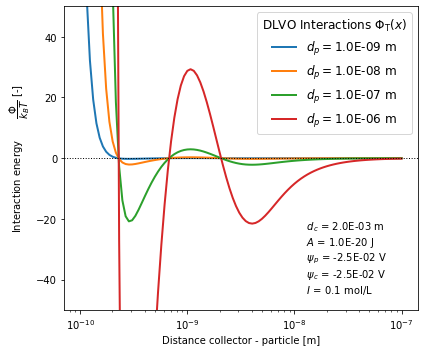

In [15]:
dpi = np.power(10.,np.array([-9,-8,-7,-6]))
rpi = dpi/2
              
plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

for rp in rpi:
    Phi_DoubleLayer = DLVO_dl(rp,psip,psic,kappa,x)
    Phi_vanderWaals = DLVO_vdW(A,rp,x)
    Phi_BornInterac = DLVO_Born(A,rp,x)
              
    Phi_TotalIntera = DLVO_T(Phi_DoubleLayer,Phi_vanderWaals,Phi_BornInterac)
               
    ax1.plot(x,Phi_TotalIntera/(BOLTZMANN*TEMP),\
         lw=2,zorder=2,\
         label="$d_p = $" + "{:.1E} m".format(rp*2))

## Straight lines
ax1.axhline(y=0.0,ls="dotted",lw=1,c="k")

## Miscelaneous
ax1.set_yscale("linear")
ax1.set_xscale("log")
ax1.set_ylabel('Interaction energy \t $\dfrac{\Phi}{k_BT}$ [-]')
ax1.set_xlabel('Distance collector - particle [m]')
ax1.set_ylim(-50,50)

# Parameters summary
paramSummary = "\
    $d_c$ = {:.1E} m \n\
    $A$ = {:.1E} J \n\
    $\psi_p$ = {:.1E} V \n\
    $\psi_c$ = {:.1E} V \n\
    $I$ = {} mol/L".format(dc,A,psip,psic,ionicStrenght)

## Legend
ax1.legend(loc="best",\
           title="DLVO Interactions $\Phi_{\\rm T}(x)$",\
           fontsize="large",title_fontsize="large")

ax1.text(1.0E-8,-20,paramSummary,\
        ha="left", va="top")

plt.tight_layout()
plt.show()

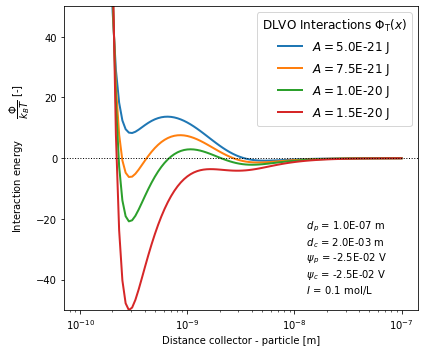

In [20]:
# Collector-particle sizes [m]
dc,dp = 2.0E-3,100.0E-9  
rc,rp = dc/2,dp/2
              
plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

Ai = [5.0E-21,7.5E-21,1.0E-20,1.5E-20]

for A in Ai:
    Phi_DoubleLayer = DLVO_dl(rp,psip,psic,kappa,x)
    Phi_vanderWaals = DLVO_vdW(A,rp,x)
    Phi_BornInterac = DLVO_Born(A,rp,x)
              
    Phi_TotalIntera = DLVO_T(Phi_DoubleLayer,Phi_vanderWaals,Phi_BornInterac)
               
    ax1.plot(x,Phi_TotalIntera/(BOLTZMANN*TEMP),\
         lw=2,zorder=2,\
         label="$A = $" + "{:.1E} J".format(A))

## Straight lines
ax1.axhline(y=0.0,ls="dotted",lw=1,c="k")

## Miscelaneous
ax1.set_yscale("linear")
ax1.set_xscale("log")
ax1.set_ylabel('Interaction energy \t $\dfrac{\Phi}{k_BT}$ [-]')
ax1.set_xlabel('Distance collector - particle [m]')
ax1.set_ylim(-50,50)

# Parameters summary
paramSummary = "\
    $d_p$ = {:.1E} m \n\
    $d_c$ = {:.1E} m \n\
    $\psi_p$ = {:.1E} V \n\
    $\psi_c$ = {:.1E} V \n\
    $I$ = {} mol/L".format(dp,dc,psip,psic,ionicStrenght)

## Legend
ax1.legend(loc="best",\
           title="DLVO Interactions $\Phi_{\\rm T}(x)$",\
           fontsize="large",title_fontsize="large")

ax1.text(1.0E-8,-20,paramSummary,\
        ha="left", va="top")

plt.tight_layout()
plt.show()

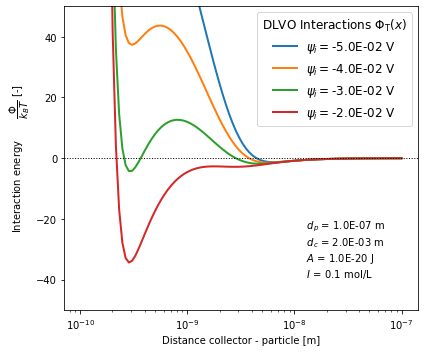

In [29]:
A = 1.0E-20
              
plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)
psi_i = np.array([-50,-40,-30,-20])*1.0E-3

for psi in psi_i:
    psip = psi
    psic = psi
    Phi_DoubleLayer = DLVO_dl(rp,psip,psic,kappa,x)
    Phi_vanderWaals = DLVO_vdW(A,rp,x)
    Phi_BornInterac = DLVO_Born(A,rp,x)
              
    Phi_TotalIntera = DLVO_T(Phi_DoubleLayer,Phi_vanderWaals,Phi_BornInterac)
               
    ax1.plot(x,Phi_TotalIntera/(BOLTZMANN*TEMP),\
         lw=2,zorder=2,\
         label="$\psi_i = $" + "{:.1E} V".format(psi))

## Straight lines
ax1.axhline(y=0.0,ls="dotted",lw=1,c="k")

## Miscelaneous
ax1.set_yscale("linear")
ax1.set_xscale("log")
ax1.set_ylabel('Interaction energy \t $\dfrac{\Phi}{k_BT}$ [-]')
ax1.set_xlabel('Distance collector - particle [m]')
ax1.set_ylim(-50,50)

# Parameters summary
paramSummary = "\
    $d_p$ = {:.1E} m \n\
    $d_c$ = {:.1E} m \n\
    $A$ = {:.1E} J \n\
    $I$ = {} mol/L".format(dp,dc,A,ionicStrenght)

## Legend
ax1.legend(loc="best",\
           title="DLVO Interactions $\Phi_{\\rm T}(x)$",\
           fontsize="large",title_fontsize="large")

ax1.text(1.0E-8,-20,paramSummary,\
        ha="left", va="top")

plt.tight_layout()
plt.show()

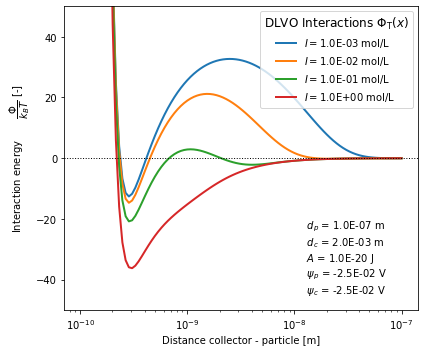

In [41]:
A = 1.0E-20
psip,psic = -25.0E-3,-25.0E-3
              
plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

I_i = [0.001,0.01,0.1,1.0]

for I in I_i:
    kappa2 = DebbyHuckel(I)
    Phi_DoubleLayer = DLVO_dl(rp,psip,psic,kappa2,x)
    Phi_vanderWaals = DLVO_vdW(A,rp,x)
    Phi_BornInterac = DLVO_Born(A,rp,x)
              
    Phi_TotalIntera = DLVO_T(Phi_DoubleLayer,Phi_vanderWaals,Phi_BornInterac)
               
    ax1.plot(x,Phi_TotalIntera/(BOLTZMANN*TEMP),\
         lw=2,zorder=2,\
         label="$I = $" + "{:.1E} mol/L".format(I))

## Straight lines
ax1.axhline(y=0.0,ls="dotted",lw=1,c="k")

## Miscelaneous
ax1.set_yscale("linear")
ax1.set_xscale("log")
ax1.set_ylabel('Interaction energy \t $\dfrac{\Phi}{k_BT}$ [-]')
ax1.set_xlabel('Distance collector - particle [m]')
ax1.set_ylim(-50,50)

# Parameters summary
paramSummary = "\
    $d_p$ = {:.1E} m \n\
    $d_c$ = {:.1E} m \n\
    $A$ = {:.1E} J \n\
    $\psi_p$ = {:.1E} V \n\
    $\psi_c$ = {:.1E} V \n".format(dp,dc,A,psip,psic)

## Legend
ax1.legend(loc="upper right",\
           title="DLVO Interactions $\Phi_{\\rm T}(x)$",\
           fontsize="medium",title_fontsize="large")

ax1.text(1.0E-8,-20,paramSummary,\
        ha="left", va="top")

plt.tight_layout()
plt.show()